
# Analisis de optimización del chunk size en el RAG

Este análisis investiga cómo influye el tamaño del fragmento (`chunk_size`) en el rendimiento y calidad de un sistema de Recuperación-Augmentada con Generación (RAG) aplicado a un tutor inteligente de estructuras de datos y algoritmos.

### Objetivos
- Comparar distintos tamaños de `chunk` para medir su impacto en:
  - Tiempo de recuperación.
  - Puntaje de similitud.
  - Calidad de las respuestas generadas.
- Determinar un `chunk_size` óptimo que balancee velocidad y relevancia.


Primero carguemos los documentos y hagamos chunkeo con diferentes tamaños de chunk

In [40]:
import os
from dotenv import dotenv_values
from utils.document_load import load_documents
from utils.embedding_loader import embedding_loader
from utils.chunking.globals import test_queries
from utils.chunking.chunk_optimization import (
    evaluate_chunk_size_performance,
    calculate_optimization_score,
    analyze_chunk_stats
)
from utils.chunking.chunking import chunk_with_different_sizes, create_vector_stores, chunk_docs

In [41]:
documents = load_documents("../data/algoritmos")
print(f"[DEBUG]{len(documents)} documentos cargados.")

config = dotenv_values("../.env")
os.environ["GOOGLE_API_KEY"] = config["GOOGLE_API_KEY_1"]
test_chunk_sizes = [256, 1024]

chunked_docs = chunk_with_different_sizes(documents, test_chunk_sizes)
vector_stores = create_vector_stores(chunked_docs)

Documentos PDF cargados: 0
Documentos Markdown cargados: 18
[DEBUG]18 documentos cargados.
[DEBUG] Creating vector store for chunk size 256...
[DEBUG] Vector store created with 756 chunks
[DEBUG] Creating vector store for chunk size 1024...
[DEBUG] Vector store created with 161 chunks


Ahora, obtengamos algunas medidas estadisticas sobre los datos de los chunks, como la cantidad de chunks totales, la longitud media, maxima y minima y la desviación estándar. 

In [42]:
# obtenemos algunas estadisticas de los chunks
chunk_stats_df = analyze_chunk_stats(chunked_docs)
chunk_stats_df

print("Chunk Statistics:")
print(chunk_stats_df.round(2))

Chunk Statistics:
   chunk_size  num_chunks  avg_length  min_length  max_length  std_length
0         256         756      181.67          10         255       73.78
1        1024         161      845.92          45        1023      194.45


Procedamos a evaluar el rendimiento del rag con algunas queries prederminadas, con el objetivo de recolectar algunas metricas como el timpo promedio de respuesta, el promedio de similitud y el promedio de la longitud de chunk recuperada.

In [43]:
# Evaluamos el rendimiento con diferentes tamaños de chunk
from random import sample
sampled_queries = test_queries
performance_df = evaluate_chunk_size_performance(vector_stores, sampled_queries)
print("\nPerformance Results:")
print(performance_df.groupby('chunk_size').agg({
    'retrieval_time': 'mean',
    'avg_similarity_score': 'mean',
    'avg_chunk_length': 'mean'
}).round(4))

[DEBUG] Testing query: 'What is the difference between a singly linked lis...'
[DEBUG] Testing query: 'Can you explain how binary search works and when i...'
[DEBUG] Testing query: 'Which data structure is best for implementing a pr...'
[DEBUG] Testing query: 'How can I balance a binary search tree?...'
[DEBUG] Testing query: 'What is a hash table and how does it handle collis...'
[DEBUG] Testing query: 'Could you explain Dijkstra's algorithm with an exa...'
[DEBUG] Testing query: 'What is the time complexity of the quicksort algor...'
[DEBUG] Testing query: 'Why would we use a heap instead of a regular array...'
[DEBUG] Testing query: 'How do I implement a stack using only queues?...'
[DEBUG] Testing query: 'What does it mean for an algorithm to be stable?...'
[DEBUG] Testing query: 'What are the differences between dynamic programmi...'
[DEBUG] Testing query: 'Can you give me exercises to practice AVL trees?...'
[DEBUG] Testing query: 'How can I determine if a graph has a cycle?...'



# Análisis de Varianza (ANOVA)

Para determinar si el tamaño del chunk tiene un impacto significativo en métricas clave, como el promedio de similitud o relevancia, aplicamos un **ANOVA**.

Este análisis permite comparar las medias entre varios grupos (en este caso, distintos `chunk_size`) y verificar si las diferencias observadas son estadísticamente significativas.


In [44]:
from scipy.stats import f_oneway

# Agrupar puntajes de similitud por chunk size
groups_similarity = [
    performance_df[performance_df.chunk_size == size]["avg_similarity_score"].dropna().values
    for size in sorted(performance_df.chunk_size.unique())
]

# ANOVA para puntaje de similitud
f_stat_sim, p_val_sim = f_oneway(*groups_similarity)

print(f"🔍 ANOVA Puntaje de Similitud → F = {f_stat_sim:.4f}, p = {p_val_sim:.4f}")
if p_val_sim < 0.05:
    print("✅ Hay diferencias estadísticamente significativas entre los tamaños de chunk en la similitud.")
else:
    print("❌ No se encontraron diferencias significativas en la similitud entre los tamaños de chunk.")

🔍 ANOVA Puntaje de Similitud → F = 3.4919, p = 0.0694
❌ No se encontraron diferencias significativas en la similitud entre los tamaños de chunk.


Antes de confiar en los resultados del ANOVA aplicado al puntaje de similitud (`avg_similarity_score`), es fundamental verificar si se cumplen sus supuestos estadísticos. Esto garantiza que las conclusiones sean válidas y no se vean afectadas por violaciones a los criterios del modelo.


In [45]:
from scipy.stats import shapiro

print("🔍 Prueba de normalidad (Shapiro-Wilk) por chunk size:")
for size in sorted(performance_df.chunk_size.unique()):
    scores = performance_df[performance_df.chunk_size == size]["avg_similarity_score"].dropna().values
    if len(scores) >= 3:
        stat, p = shapiro(scores)
        print(f"  Chunk size {size} → W = {stat:.4f}, p = {p:.4f} → {'Normal' if p > 0.05 else 'No normal'}")
    else:
        print(f"  Chunk size {size} → Insuficientes datos para prueba de Shapiro")


🔍 Prueba de normalidad (Shapiro-Wilk) por chunk size:
  Chunk size 256 → W = 0.9672, p = 0.6959 → Normal
  Chunk size 1024 → W = 0.9212, p = 0.1044 → Normal


Utilizamos la **prueba de Shapiro-Wilk** para evaluar si los puntajes de similitud dentro de cada grupo (`chunk_size`) siguen una distribución normal.

- Si el valor **p > 0.05**, no se rechaza la hipótesis de normalidad.
- Si el valor **p < 0.05**, se considera que los datos no son normales.

La normalidad es un requisito importante para aplicar ANOVA de forma confiable.


In [46]:
from scipy.stats import levene

groups_similarity = [
    performance_df[performance_df.chunk_size == size]["avg_similarity_score"].dropna().values
    for size in sorted(performance_df.chunk_size.unique())
]
groups_similarity = [g for g in groups_similarity if len(g) >= 2]

stat_levene, p_levene = levene(*groups_similarity)

print(f"\nPrueba de Levene (igualdad de varianzas): W = {stat_levene:.4f}, p = {p_levene:.4f}")
if p_levene > 0.05:
    print("Se cumple la homogeneidad de varianzas.")
else:
    print("No se cumple la homogeneidad de varianzas. El ANOVA podría no ser fiable.")



Prueba de Levene (igualdad de varianzas): W = 0.1444, p = 0.7061
Se cumple la homogeneidad de varianzas.


La **prueba de Levene** evalúa si las varianzas de los puntajes de similitud son iguales entre los distintos `chunk_size`.

- Si **p > 0.05**, se considera que las varianzas son homogéneas (se cumple el supuesto).
- Si **p < 0.05**, las varianzas son significativamente diferentes (violación del supuesto de ANOVA).

Esta verificación es clave para que la comparación entre grupos sea válida.

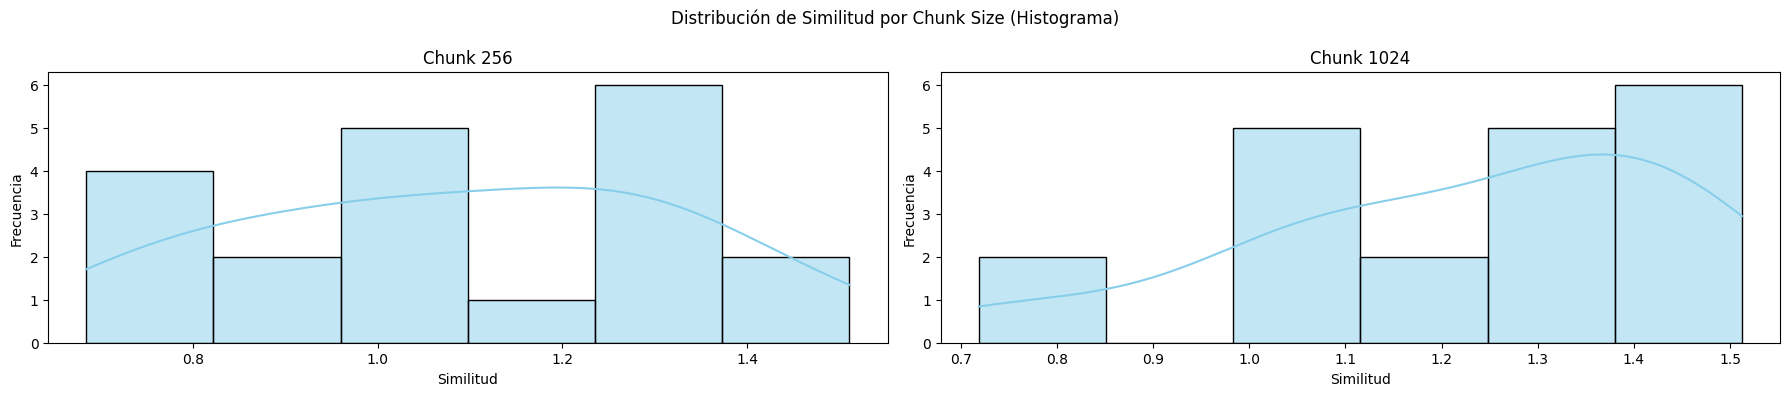

/tmp/ipykernel_2819/1782656624.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=performance_df, x="chunk_size", y="avg_similarity_score", palette="pastel")


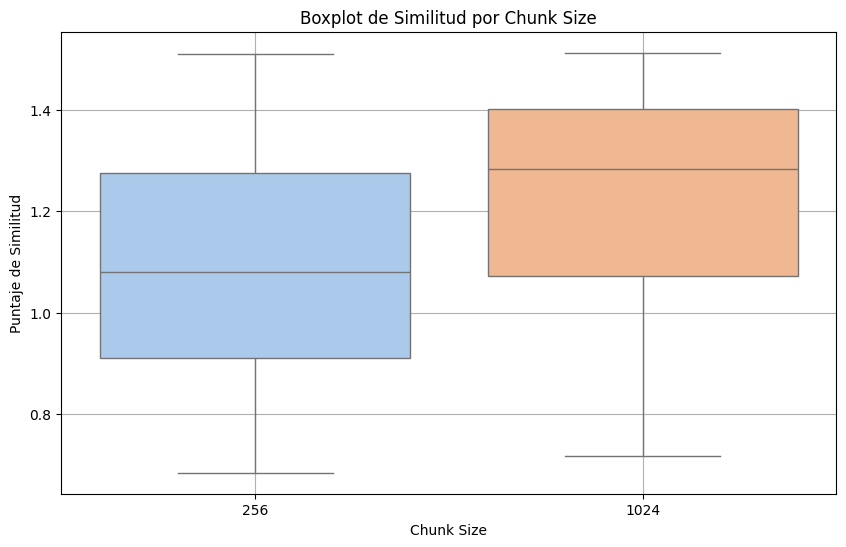

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

fig, axs = plt.subplots(1, len(performance_df.chunk_size.unique()), figsize=(18, 4))
fig.suptitle("Distribución de Similitud por Chunk Size (Histograma)")

for i, size in enumerate(sorted(performance_df.chunk_size.unique())):
    scores = performance_df[performance_df.chunk_size == size]["avg_similarity_score"].dropna().values
    sns.histplot(scores, kde=True, ax=axs[i], color="skyblue")
    axs[i].set_title(f"Chunk {size}")
    axs[i].set_xlabel("Similitud")
    axs[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

# Boxplot para comparar varianzas
plt.figure(figsize=(10, 6))
sns.boxplot(data=performance_df, x="chunk_size", y="avg_similarity_score", palette="pastel")
plt.title("Boxplot de Similitud por Chunk Size")
plt.xlabel("Chunk Size")
plt.ylabel("Puntaje de Similitud")
plt.grid(True)
plt.show()


Los resultados de las pruebas estadísticas y visualizaciones permiten evaluar si el análisis de varianza aplicado es fiable.

- Si se cumplen **normalidad** y **homogeneidad de varianzas**, el ANOVA es válido.
- En caso contrario, se recomienda usar pruebas no paramétricas como **Kruskal-Wallis** para comparar grupos.

Este análisis respalda la rigurosidad metodológica de la evaluación de `chunk_size` en el sistema RAG.

## Comparación de Medias de Similitud entre Chunk Sizes (Bootstrapping)

Con el fin de comparar las medias de similitud (`avg_similarity_score`) entre distintos `chunk_size`, aplicamos la técnica de **bootstrapping** para estimar intervalos de confianza del 95%.

Esta técnica no asume normalidad ni igualdad de varianzas, y permite evaluar si las diferencias observadas entre las medias son estadísticamente relevantes.


In [48]:
import numpy as np
import pandas as pd

def bootstrap_mean_ci(data, n_iterations=1000, ci=95):
    means = []
    for _ in range(n_iterations):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    lower = np.percentile(means, (100 - ci) / 2)
    upper = np.percentile(means, 100 - (100 - ci) / 2)
    return np.mean(data), lower, upper

In [49]:
bootstrap_results = []

for size in sorted(performance_df.chunk_size.unique()):
    scores = performance_df[performance_df.chunk_size == size]["avg_similarity_score"].dropna().values
    if len(scores) > 1:
        mean, lower, upper = bootstrap_mean_ci(scores, n_iterations=1000)
        bootstrap_results.append({
            "chunk_size": size,
            "mean_similarity": mean,
            "ci_lower": lower,
            "ci_upper": upper
        })

bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_df


,chunk_size,mean_similarity,ci_lower,ci_upper
0,256,1.087592,0.987170,1.193434
1,1024,1.224542,1.122174,1.321686


### Interpretación

La tabla anterior muestra la media estimada del puntaje de similitud y su intervalo de confianza del 95% para cada tamaño de chunk. Si los intervalos **no se solapan entre dos grupos**, puede interpretarse como una diferencia estadísticamente significativa entre sus medias.


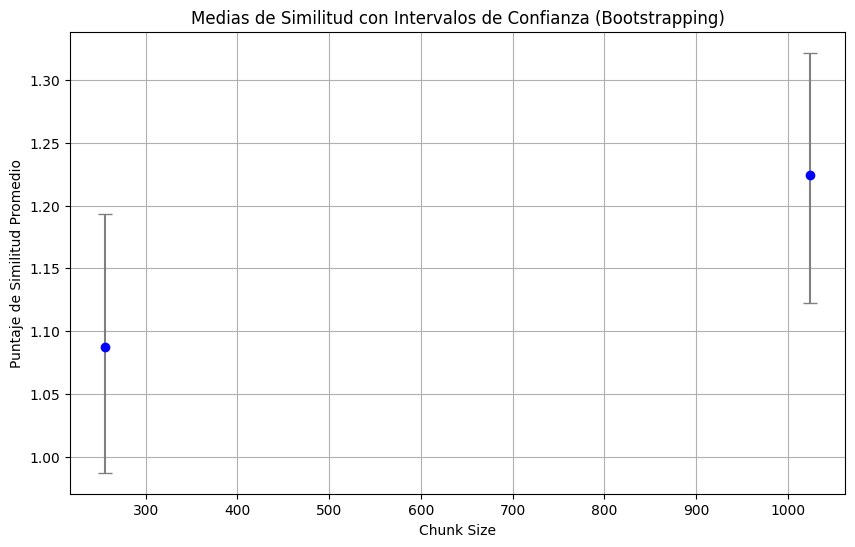

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(
    bootstrap_df["chunk_size"], 
    bootstrap_df["mean_similarity"], 
    yerr=[bootstrap_df["mean_similarity"] - bootstrap_df["ci_lower"], 
          bootstrap_df["ci_upper"] - bootstrap_df["mean_similarity"]],
    fmt='o', capsize=5, color='blue', ecolor='gray'
)
plt.title("Medias de Similitud con Intervalos de Confianza (Bootstrapping)")
plt.xlabel("Chunk Size")
plt.ylabel("Puntaje de Similitud Promedio")
plt.grid(True)
plt.show()


### Conclusión

Los resultados obtenidos mediante bootstrapping confirman (o no) si existen diferencias relevantes entre los `chunk_size` al analizar la similitud de los fragmentos recuperados.

Esta técnica proporciona una estimación robusta y visualmente interpretable, útil para decidir el tamaño óptimo de fragmentos en la arquitectura RAG.


In [51]:
from utils.chunking.chunk_optimization import calculate_optimization_score

score_df = calculate_optimization_score(performance_df, None, None)
best_chunk_size = int(score_df.iloc[0]['chunk_size'])
print("Chunk size óptimo:", best_chunk_size)
final_chunks = chunk_docs(documents, best_chunk_size, ["\n\n", "\n", " ", ""])

Chunk size óptimo: 1024
